# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of model goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and validation (val) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you should select your final/best model and hyperparameters to run one time only and then make the business performance tables for that final model. Note once we've decided on the final model and hyperparameters we're allowed to make several trial runs of our final model train looking for a good performance on the testing data, as long as we don't make any changes to the model hyperparameters from our final choice.

Things to add: better calculation of DR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [3]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
import scipy.stats as sps
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
# This will let you see all the particular library vertsions you have loaded
# %pip list

In [5]:
# Some names and parameters
in_file = 'vars_final.csv' # name of the modeling data file
y_name = 'fraud_label' # name of the dependent variable field
record = 'record' # name for the record number field
NVARS  =  20 # how many independent variables you want to keep. Less than or equal to the # in the file
val_record = 833508 # if you want, break out some of the last records for a validation data set.
# The validation data should generally be selected randomly, but here we're doing out of time validation
nitermax = 5 # this is the number of cross validation train/tests to do for each model build

In [6]:
%%time
vars = pd.read_csv(in_file)
print(vars.shape)
vars.head()

(1000000, 22)
CPU times: total: 500 ms
Wall time: 1.04 s


,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,address_day_since,fulladdress_day_since,...,address_count_14,fulladdress_count_14,max_count_by_address_1,max_count_by_fulladdress_1,address_count_7,fulladdress_count_7,address_unique_count_for_name_homephone_60,address_count_0_by_30,record,fraud_label
0,1,1,5,1,1,30.0,365.0,1,365.0,365.0,...,1,1,1,1,1,1,1,30.0,1,0
1,1,1,6,1,1,30.0,365.0,1,365.0,365.0,...,1,1,1,1,1,1,1,30.0,2,1
2,1,1,4,1,1,30.0,365.0,1,365.0,365.0,...,1,1,1,1,1,1,1,30.0,3,0
3,1,1,4,1,1,30.0,365.0,1,365.0,365.0,...,1,1,1,1,1,1,1,30.0,4,0
4,1,1,4,1,1,30.0,365.0,1,365.0,365.0,...,1,1,1,1,1,1,1,30.0,5,0


In [7]:
num_bad = vars[y_name].sum()
num_good = len(vars) - num_bad
detect_rate = 2 * num_bad / len(vars)
numvars = min(NVARS,len(vars)-2)
print(vars.shape, num_good,num_bad,detect_rate,numvars)
final_vars_list = [record,y_name]
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

(1000000, 22) 985607 14393 0.028786 20


['record',
 'fraud_label',
 'max_count_by_address_30',
 'max_count_by_ssn_7',
 'max_count_by_homephone_7',
 'zip5_unique_count_for_dob_1',
 'max_count_by_fulladdress_30',
 'fulladdress_count_0_by_30',
 'ssn_day_since',
 'max_count_by_address_7',
 'address_day_since',
 'fulladdress_day_since',
 'max_count_by_fulladdress_3',
 'max_count_by_address_3',
 'address_count_14',
 'fulladdress_count_14',
 'max_count_by_address_1',
 'max_count_by_fulladdress_1',
 'address_count_7',
 'fulladdress_count_7',
 'address_unique_count_for_name_homephone_60',
 'address_count_0_by_30']

In [8]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,record,fraud_label,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,...,max_count_by_fulladdress_3,max_count_by_address_3,address_count_14,fulladdress_count_14,max_count_by_address_1,max_count_by_fulladdress_1,address_count_7,fulladdress_count_7,address_unique_count_for_name_homephone_60,address_count_0_by_30
0,1,0,1,1,5,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
1,2,1,1,1,6,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
2,3,0,1,1,4,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
3,4,0,1,1,4,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
4,5,0,1,1,4,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0


In [9]:
vars.shape

(1000000, 22)

In [10]:
vars[y_name].sum()

14393

In [11]:
print("y_name rate in data is",vars[y_name].sum()/len(vars))

y_name rate in data is 0.014393


In [12]:
vars.head(10)

,record,fraud_label,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,...,max_count_by_fulladdress_3,max_count_by_address_3,address_count_14,fulladdress_count_14,max_count_by_address_1,max_count_by_fulladdress_1,address_count_7,fulladdress_count_7,address_unique_count_for_name_homephone_60,address_count_0_by_30
0,1,0,1,1,5,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
1,2,1,1,1,6,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
2,3,0,1,1,4,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
3,4,0,1,1,4,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
4,5,0,1,1,4,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
5,6,0,1,1,5,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
6,7,0,1,1,4,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
7,8,0,1,1,2,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
8,9,0,1,1,5,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
9,10,0,1,1,5,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0


In [13]:
vars.shape

(1000000, 22)

In [14]:
vars.describe()

,record,fraud_label,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,...,max_count_by_fulladdress_3,max_count_by_address_3,address_count_14,fulladdress_count_14,max_count_by_address_1,max_count_by_fulladdress_1,address_count_7,fulladdress_count_7,address_unique_count_for_name_homephone_60,address_count_0_by_30
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.014393,1.179185,1.059005,4.361851,1.512163,1.143258,29.489603,327.065515,1.101238,...,1.067349,1.077997,1.054768,1.048008,1.058412,1.051635,1.042577,1.039021,1.066381,29.358254
std,288675.278933,0.119104,1.152676,0.779273,2.226316,0.964281,1.080993,2.834776,96.703231,1.019993,...,0.930598,0.944982,0.618082,0.606966,0.844120,0.833290,0.585789,0.581254,0.701078,3.205310
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.304348,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.304348
25%,250000.750000,0.000000,1.000000,1.000000,3.000000,1.000000,1.000000,30.000000,365.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000
50%,500000.500000,0.000000,1.000000,1.000000,4.000000,1.000000,1.000000,30.000000,365.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000
75%,750000.250000,0.000000,1.000000,1.000000,5.000000,2.000000,1.000000,30.000000,365.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000
max,1000000.000000,1.000000,30.000000,34.000000,33.000000,33.000000,30.000000,30.000000,365.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [15]:
# select the records that will become the validation data
validation = vars[vars[record] > val_record]
validation.head(10)

,record,fraud_label,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,...,max_count_by_fulladdress_3,max_count_by_address_3,address_count_14,fulladdress_count_14,max_count_by_address_1,max_count_by_fulladdress_1,address_count_7,fulladdress_count_7,address_unique_count_for_name_homephone_60,address_count_0_by_30
833508,833509,0,1,1,1,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
833509,833510,0,2,1,5,1,2,15.0,9.0,1,...,1,1,2,2,1,1,1,1,1,15.0
833510,833511,0,1,1,2,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
833511,833512,0,1,1,3,2,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
833512,833513,0,2,2,3,1,2,15.0,4.0,2,...,1,1,2,2,1,1,2,2,1,15.0
833513,833514,0,1,1,5,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
833514,833515,0,1,1,5,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
833515,833516,0,1,1,3,1,1,30.0,286.0,1,...,1,1,1,1,1,1,1,1,1,30.0
833516,833517,0,1,1,5,1,1,30.0,365.0,1,...,1,1,1,1,1,1,1,1,1,30.0
833517,833518,0,1,1,6,2,1,30.0,66.0,1,...,1,1,1,1,1,1,1,1,1,30.0


In [16]:
record_save = vars[record]
Y_save = pd.DataFrame(vars.loc[:,y_name])
Y_save.head()

,fraud_label
0,0
1,1
2,0
3,0
4,0


## Scale and truncate field values

In [17]:
X_no_scaling = vars.drop(columns = [record,y_name])
X_no_scaling.describe()

,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,address_day_since,fulladdress_day_since,max_count_by_fulladdress_3,max_count_by_address_3,address_count_14,fulladdress_count_14,max_count_by_address_1,max_count_by_fulladdress_1,address_count_7,fulladdress_count_7,address_unique_count_for_name_homephone_60,address_count_0_by_30
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.179185,1.059005,4.361851,1.512163,1.143258,29.489603,327.065515,1.101238,320.117207,325.060480,1.067349,1.077997,1.054768,1.048008,1.058412,1.051635,1.042577,1.039021,1.066381,29.358254
std,1.152676,0.779273,2.226316,0.964281,1.080993,2.834776,96.703231,1.019993,104.836655,99.097485,0.930598,0.944982,0.618082,0.606966,0.844120,0.833290,0.585789,0.581254,0.701078,3.205310
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.304348,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.304348
25%,1.000000,1.000000,3.000000,1.000000,1.000000,30.000000,365.000000,1.000000,365.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000
50%,1.000000,1.000000,4.000000,1.000000,1.000000,30.000000,365.000000,1.000000,365.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000
75%,1.000000,1.000000,5.000000,2.000000,1.000000,30.000000,365.000000,1.000000,365.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000
max,30.000000,34.000000,33.000000,33.000000,30.000000,30.000000,365.000000,30.000000,365.000000,365.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [18]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [19]:
# Outlier treatment: use this to limit variables. For some problems it helps
Clip = 10

In [20]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,address_day_since,fulladdress_day_since,max_count_by_fulladdress_3,max_count_by_address_3,address_count_14,fulladdress_count_14,max_count_by_address_1,max_count_by_fulladdress_1,address_count_7,fulladdress_count_7,address_unique_count_for_name_homephone_60,address_count_0_by_30
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
mean,-5.535128e-18,-1.405454e-17,-6.984635e-18,-4.064304e-17,8.029133e-19,4.590461e-17,1.449507e-17,-5.959677e-19,-1.280398e-16,1.435296e-17,-9.917400e-18,1.005951e-17,7.968737e-18,-1.385558e-18,1.659650e-17,-2.738432e-17,-4.160583e-17,4.312284e-17,1.113420e-17,7.214673e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.820282e-01,-9.940138e-02,-1.520183e+00,-5.705647e-01,-1.604064e-01,-9.942674e+00,-3.382157e+00,-1.188280e-01,-3.053486e+00,-3.280209e+00,-8.538659e-02,-1.000513e-01,-1.133832e-01,-1.007242e-01,-8.618453e-02,-7.468594e-02,-9.235228e-02,-8.401870e-02,-1.133567e-01,-8.752323e+00
25%,-1.820282e-01,-9.940138e-02,-6.154198e-01,-5.705647e-01,-1.604064e-01,1.800485e-01,3.922773e-01,-1.188280e-01,4.281212e-01,4.030326e-01,-8.538659e-02,-1.000513e-01,-1.133832e-01,-1.007242e-01,-8.618453e-02,-7.468594e-02,-9.235228e-02,-8.401870e-02,-1.133567e-01,2.002135e-01
50%,-1.820282e-01,-9.940138e-02,-1.630385e-01,-5.705647e-01,-1.604064e-01,1.800485e-01,3.922773e-01,-1.188280e-01,4.281212e-01,4.030326e-01,-8.538659e-02,-1.000513e-01,-1.133832e-01,-1.007242e-01,-8.618453e-02,-7.468594e-02,-9.235228e-02,-8.401870e-02,-1.133567e-01,2.002135e-01
75%,-1.820282e-01,-9.940138e-02,2.893429e-01,5.544847e-01,-1.604064e-01,1.800485e-01,3.922773e-01,-1.188280e-01,4.281212e-01,4.030326e-01,-8.538659e-02,-1.000513e-01,-1.133832e-01,-1.007242e-01,-8.618453e-02,-7.468594e-02,-9.235228e-02,-8.401870e-02,-1.133567e-01,2.002135e-01
max,1.296144e+01,1.779291e+01,1.007209e+01,1.085428e+01,1.391674e+01,1.800485e-01,3.922773e-01,1.470606e+01,4.281212e-01,4.030326e-01,1.636617e+01,1.593272e+01,1.616062e+01,1.677699e+01,1.758054e+01,1.795229e+01,1.722214e+01,1.759172e+01,1.458426e+01,2.002135e-01


In [21]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this val record number to whatever is appropriate for your data
X_trntst = X[0:val_record]
Y_trntst = Y_save[0:val_record]
X_val = X[val_record:]
Y_val = Y_save[val_record:]
Y_val.sum()

fraud_label    2386
dtype: int64

## Look at PCA

In [22]:
len(X_trntst.columns)

20

In [23]:
X_trntst_save = X_trntst.copy()

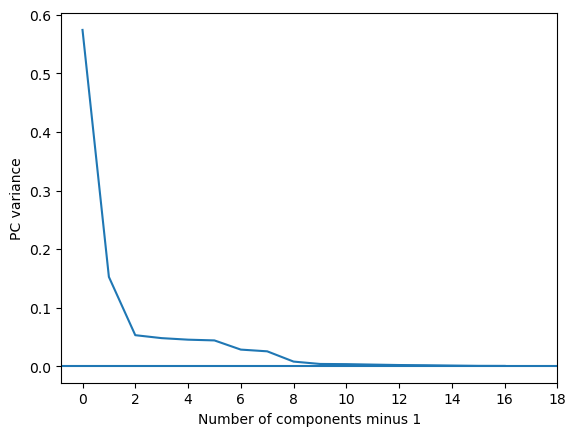

In [24]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [25]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-0.580208,0.546289,-0.094081,0.065658
1,-0.549213,0.560009,0.107957,-0.061580
2,-0.611203,0.532568,-0.296119,0.192897
3,-0.611203,0.532568,-0.296119,0.192897
4,-0.611203,0.532568,-0.296119,0.192897


In [26]:
princ_comps = pca.transform(X_val)
X_val_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_val.index)
X_val_orig_pca.head()

,PC1,PC2,PC3,PC4
833508,-0.704189,0.491408,-0.902234,0.574613
833509,4.281489,-7.646094,-2.329579,-0.182874
833510,-0.673194,0.505128,-0.700196,0.447374
833511,-0.525531,0.608338,-0.290019,0.038828
833512,6.331294,-7.456029,-2.268745,2.260046


In [27]:
X_trntst.describe()

,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,address_day_since,fulladdress_day_since,max_count_by_fulladdress_3,max_count_by_address_3,address_count_14,fulladdress_count_14,max_count_by_address_1,max_count_by_fulladdress_1,address_count_7,fulladdress_count_7,address_unique_count_for_name_homephone_60,address_count_0_by_30
count,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000,833508.000000
mean,0.002161,-0.001128,-0.000317,-0.000569,0.002509,0.000687,0.031898,0.001607,0.031613,0.031520,0.001719,0.001679,0.000541,0.000817,0.001394,0.001457,0.000948,0.001114,-0.000217,0.000987
std,1.006456,0.989197,0.999108,1.002975,1.008758,0.998151,0.979457,1.010591,0.983235,0.981265,1.012322,1.011293,1.004619,1.006464,1.008852,1.009325,1.007963,1.009002,1.000922,0.997511
min,-0.182028,-0.099401,-1.520183,-0.570565,-0.160406,-9.942674,-3.382157,-0.118828,-3.053486,-3.280209,-0.085387,-0.100051,-0.113383,-0.100724,-0.086185,-0.074686,-0.092352,-0.084019,-0.113357,-8.752323
25%,-0.182028,-0.099401,-0.615420,-0.570565,-0.160406,0.180049,0.392277,-0.118828,0.428121,0.403033,-0.085387,-0.100051,-0.113383,-0.100724,-0.086185,-0.074686,-0.092352,-0.084019,-0.113357,0.200213
50%,-0.182028,-0.099401,-0.163038,-0.570565,-0.160406,0.180049,0.392277,-0.118828,0.428121,0.403033,-0.085387,-0.100051,-0.113383,-0.100724,-0.086185,-0.074686,-0.092352,-0.084019,-0.113357,0.200213
75%,-0.182028,-0.099401,0.289343,0.554485,-0.160406,0.180049,0.392277,-0.118828,0.428121,0.403033,-0.085387,-0.100051,-0.113383,-0.100724,-0.086185,-0.074686,-0.092352,-0.084019,-0.113357,0.200213
max,12.961438,17.792912,10.072093,10.854276,13.916738,0.180049,0.392277,14.706061,0.428121,0.403033,16.366167,15.932720,16.160620,16.776993,17.580538,17.952289,17.222145,17.591717,14.584262,0.200213


In [28]:
X_val_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,166492.000000,166492.000000,166492.000000,166492.000000
mean,0.032727,-0.281626,0.113098,-0.068315
std,3.220790,1.847660,1.096328,1.049021
min,-0.704189,-9.555186,-13.274890,-5.542545
25%,-0.611203,-0.377610,-0.296119,-0.369718
50%,-0.494536,0.532568,-0.087981,-0.061580
75%,-0.205964,0.588507,0.328296,0.192897
max,57.866857,12.970699,17.171566,17.174532


In [29]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_val_orig_pca = (X_val_orig_pca - mean)/stdev

In [30]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.335080e+05,8.335080e+05,8.335080e+05,8.335080e+05
mean,-3.614484e-18,5.101196e-17,-7.501759e-18,1.227561e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.075140e-01,-6.018923e+00,-1.243823e+01,-4.680693e+00
25%,-1.801126e-01,2.964705e-01,-2.865104e-01,-2.192859e-01
50%,-1.618450e-01,3.121501e-01,-9.102830e-02,6.676564e-02
75%,-1.113522e-01,3.554448e-01,1.162584e-01,1.961501e-01
max,1.709323e+01,7.455576e+00,1.850149e+01,1.937239e+01


In [31]:
X_val_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,166492.000000,166492.000000,166492.000000,166492.000000
mean,0.009644,-0.160922,0.109428,-0.069467
std,0.949119,1.055755,1.060753,1.066712
min,-0.207514,-5.459847,-12.844128,-5.636018
25%,-0.180113,-0.215767,-0.286510,-0.375953
50%,-0.145732,0.304310,-0.085126,-0.062619
75%,-0.060694,0.336274,0.317643,0.196150
max,17.052506,7.411477,16.614358,17.464176


In [32]:
X_trntst_pca.shape

(833508, 4)

In [33]:
X_val_orig_pca.shape

(166492, 4)

## Subsample the larger class if desired

In [34]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp[y_name] = Y_trntst[y_name]
temp.head()
goods = temp[temp[y_name]==0]
bads = temp[temp[y_name]==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled[y_name])
X_trntst_sampled = all_sampled.drop(columns=[y_name])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.014405380632219487
(23841, 20) 23841


In [35]:
# We do a manual cross validation by running each model nitermax times for each choice of hyperparameters. The good
# statistical measurement of the model performance is the average across all these nitermax runs.
niter = 0
jittersize = .1
X_val_orig = X_val.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and/or just explore one model type. You can also just rerun any single cell multiple times (hit shift-enter on that cell) as you "manually" explore different model hyperparameters.

In [36]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','val'],index=range(1000))
counter = 0
model_counter = 0

In [37]:
logreg_params = {
    'penalty': 'l2',
    'C': 1,
    'solver': 'lbfgs',
    'l1_ratio': None,
    'max_iter' : 1000
}

In [38]:
# %%time
# # Logistic regression

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = LogisticRegression(**logreg_params)
 
#     X_val = X_val_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trn_save[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_tst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['log reg',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [39]:
# dt_params = {
#     'criterion': 'gini',
#     'splitter': 'best',
#     'max_depth': None,
#     'min_samples_split': 2,
#     'min_samples_leaf': 1
# }

In [40]:
# %%time
# # Single DT

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     min_split = 90
#     model = DecisionTreeClassifier(**dt_params)
 
#     X_val = X_val_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trn_save[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_tst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['DT',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1

# print(DR.mean())
# model_counter = model_counter + 1

In [41]:
# rf_params = {
#     'n_estimators': 100,
#     'criterion': 'entropy',
#     'max_depth': None,
#     'min_samples_split': 150,
#     'min_samples_leaf': 50,
#     'n_jobs': -1
# }

In [42]:
# %%time
# # RF

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     min_split = 100
#     model = RandomForestClassifier(**rf_params)
#     X_val = X_val_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trn_save[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_tst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['RF',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [43]:
# bt_params = {
#     'num_leaves': 31,
#     'max_depth': -1,
#     'learning_rate':0.01,
#     'n_estimators': 200,
#     'n_jobs': -1
# }

In [44]:
# %%time
# # LGBM

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = lgb.LGBMClassifier(**bt_params)

#     X_val = X_val_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trn_save[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_tst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter,'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['LGBM',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [45]:
# %%time
# # LGBM with SMOTE
# from imblearn.over_sampling import SMOTE

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     sm = SMOTE()
    
#     X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
#     print(niter, X_trn.shape,Y_trn.shape)
#     print(niter, X_trn_sm.shape,Y_trn_sm.shape)
#     print(Y_trn.sum())
#     print(Y_trn_sm.sum())

#     model = lgb.LGBMClassifier()

#     X_val = X_val_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trn_save[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_tst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter,'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['LGBM with SMOTE',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [46]:
# %%time
# # LGBM with jitter

# jittersize = .1
# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     print(niter, X_trn.shape,Y_trn.shape)
    
#     X_trn_bads = X_trn[Y_trn == 1]
#     Y_trn_bads = Y_trn[Y_trn == 1]
    
#     print(X_trn_bads.head())
#     for i in range(2):
#         X_trn_more = X_trn_bads*(1+jittersize*random.uniform(-1,1))
#         X_trn = X_trn.append(X_trn_more,ignore_index=True)
#         Y_trn = Y_trn.append(Y_trn_bads,ignore_index=True)
        
#     print(niter, X_trn.shape,Y_trn.shape)

#     model = lgb.LGBMClassifier()

#     X_val = X_val_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trn_save[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_tst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter,'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['LGBM with jitter',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [47]:
nn_params = {
    'hidden_layer_sizes': (1000,),
    'activation': 'tanh',
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.0001,
    'max_iter': 1000
}

In [48]:
%%time
# NN

DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
      
    model = MLPClassifier(**nn_params)

    X_val = X_val_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn[y_name] = Y_trn_save[y_name]
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst[y_name] = Y_tst[y_name]
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

    predictions = model.predict_proba(X_val)[:,1]
    X_val['predicted']=predictions
    X_val[y_name] = Y_val[y_name]
    topRows = int(round(X_val.shape[0]*detect_rate))
    temp = X_val.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
    print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
    Modeling_output.iloc[counter] = ['NN',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
    counter = counter + 1
    
print(DR.mean())
model_counter = model_counter + 1

0 0.6159618820726623 0.6137873754152824 0.5850796311818944
1 0.6147791353383458 0.6163090128755365 0.5821458507963119
2 0.6080968775970557 0.6177455357142857 0.5800502933780386
3 0.6023391812865497 0.62651598676957 0.5783738474434199
4 0.6128459900638751 0.6149732620320856 0.5804694048616932
trn    0.610805
tst    0.617866
val    0.581224
dtype: float64
CPU times: total: 14min 28s
Wall time: 28min 52s


In [ ]:
# %%time
# # NN on pc's

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier()

#     X_val = X_val_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trn_save[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_tst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['NN_PCs',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [ ]:
# %%time
# # GBC

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier()

#     X_val = X_val_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trn_save[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_tst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['GBC',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [ ]:
# %%time
# # Catboost

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0)

#     X_val = X_val_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trn_save[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_tst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['cat boost',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [ ]:
# %%time
# # NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# # Only use this cell if you do downsampling of the goods.
# # each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# # it's hard to get the correct DR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

#     model = lgb.LGBMClassifier()

#     model.fit(X_trn, Y_trn.values.ravel())  
    
#     X_val = X_val_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trntst[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_trntst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['LGBM sampled',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [ ]:
# %%time
# # Catboost on pc's

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0)
# #             learning_rate=detect_rate,
# #             l2_leaf_reg=5  
# #

#     X_val = X_val_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trn_save[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_tst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [ ]:
# %%time
# # unsupervised model using pc's. 

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_val = X_val_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trn_save[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_tst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = ((X_val.abs()**pow).sum(axis=1))**oop
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [ ]:
# %%time
# # XGB

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = xgb.XGBClassifier(booster='gbtree')

#     X_val = X_val_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trn_save[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_tst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['XGB',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [ ]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
#     model = KNeighborsClassifier() 
    
#     X_val = X_val_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trn_save[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_tst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['Knn',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [ ]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(kernel='poly',probability=True)
    
#     X_val = X_val_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn[y_name] = Y_trn_save[y_name]
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst[y_name] = Y_tst[y_name]
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val[y_name] = Y_val[y_name]
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,y_name]
#     DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = ['SVM',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [ ]:
df = Modeling_output.dropna()
df.head(20)

In [ ]:
df.shape

In [ ]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','val'], var_name=['Type'], value_name='Value')
df_unpivot.head()

In [ ]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='val')]
df_compare.head()

In [ ]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'val':['mean','std']})
output

In [ ]:
df.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.5,.65)
plt.ylabel('Score (DR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [ ]:
best_val = df['val'].max()
row = df.loc[df['val'] == best_val]
best_model = row['Model']
print(best_model, '\n', best_val)

In [ ]:
%%time
# Note - need to set this next value to around the highest val DR for your model of choice.
# The model then runs a nomber of times with your fixed hyperparameters until it finds a good model.

for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the val performance where I want to break out this loop
# and that will be my final model run of choice
    model = lgb.LGBMClassifier()

    X_val = X_val_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn[y_name] = Y_trn_save[y_name]
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst[y_name] = Y_tst[y_name]
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

    predictions = model.predict_proba(X_val)[:,1]
    X_val['predicted']=predictions
    X_val[y_name] = Y_val[y_name]
    topRows = int(round(X_val.shape[0]*detect_rate))
    temp = X_val.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
    print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
    Modeling_output.iloc[counter] = ['LGBM',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
    counter = counter + 1
# choose a good break point
    if(DR.loc[niter, 'val'] >= best_val): break
    
model_counter = model_counter + 1

In [ ]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_val_eval = X_val.copy()

In [ ]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','DR','KS','FPR']
DR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
DR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
DR_val = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
val_sorted = X_val_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, y_name])
bad_tot_tst = sum(X_tst_eval.loc[:, y_name])
bad_tot_val = sum(X_val_eval.loc[:, y_name])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_val = len(X_val_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_val = num_tot_val - bad_tot_val
val_sorted.head(20)

In [ ]:
cost_y_name = 
cost_fp = 
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_val = int(round(X_val_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_val = val_sorted.head(percent_rows_val)
    num_bad_trn = sum(temp_trn.loc[:,y_name])
    num_bad_tst = sum(temp_tst.loc[:,y_name])
    num_bad_val = sum(temp_val.loc[:,y_name])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_val = len(temp_val)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_val = num_tot_val - num_bad_val
    
    DR_trn.loc[i, 'bin'] = i
    DR_trn.loc[i,'#recs'] = 0
    DR_trn.loc[i, 'tot'] = num_tot_trn
    DR_trn.loc[i, 'cg'] = num_good_trn
    DR_trn.loc[i, 'cb'] = num_bad_trn
    DR_trn.loc[i, 'y_name Savings'] = DR_trn.loc[i, 'cb'] * cost_y_name
    DR_trn.loc[i, 'FP Loss'] = DR_trn.loc[i, 'cg'] * cost_fp
    DR_trn.loc[i, 'Overall Savings'] = DR_trn.loc[i, 'y_name Savings'] - DR_trn.loc[i, 'FP Loss']
    DR_tst.loc[i, 'bin'] = i
    DR_tst.loc[i, 'tot'] = num_tot_tst
    DR_tst.loc[i, 'cg'] = num_good_tst
    DR_tst.loc[i, 'cb'] = num_bad_tst
    DR_tst.loc[i, 'y_name Savings'] = DR_tst.loc[i, 'cb'] * cost_y_name
    DR_tst.loc[i, 'FP Loss'] = DR_tst.loc[i, 'cg'] * cost_fp
    DR_tst.loc[i, 'Overall Savings'] = DR_tst.loc[i, 'y_name Savings'] - DR_tst.loc[i, 'FP Loss']
    DR_val.loc[i, 'bin'] = i
    DR_val.loc[i, 'tot'] = num_tot_val
    DR_val.loc[i, 'cg'] = num_good_val
    DR_val.loc[i, 'cb'] = num_bad_val

    if i != 0:
        DR_trn.loc[i, '#g'] = num_good_trn - DR_trn.loc[i-1, 'cg']
        DR_trn.loc[i, '#b'] = num_bad_trn - DR_trn.loc[i-1, 'cb']
        DR_trn.loc[i,'#recs'] = DR_trn.loc[i, '#g'] + DR_trn.loc[i, '#b']
        DR_trn.loc[i, '%g'] = 100* (num_good_trn - DR_trn.loc[i-1, 'cg']) / (num_tot_trn - DR_trn.loc[i-1, 'tot'])
        DR_trn.loc[i, '%b'] = 100 - DR_trn.loc[i, '%g']
        DR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        DR_trn.loc[i, 'DR'] = 100 * num_bad_trn / bad_tot_trn
        DR_trn.loc[i, 'KS'] = DR_trn.loc[i, 'DR'] - DR_trn.loc[i, '%cg']
        DR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        DR_tst.loc[i, '#g'] = num_good_tst - DR_tst.loc[i-1, 'cg']
        DR_tst.loc[i, '#b'] = num_bad_tst - DR_tst.loc[i-1, 'cb']
        DR_tst.loc[i,'#recs'] = DR_tst.loc[i, '#g'] + DR_tst.loc[i, '#b']
        DR_tst.loc[i, '%g'] = 100* (num_good_tst - DR_tst.loc[i-1, 'cg']) / (num_tot_tst - DR_tst.loc[i-1, 'tot'])
        DR_tst.loc[i, '%b'] = 100 - DR_tst.loc[i, '%g']
        DR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        DR_tst.loc[i, 'DR'] = 100 * num_bad_tst / bad_tot_tst
        DR_tst.loc[i, 'KS'] = DR_tst.loc[i, 'DR'] - DR_tst.loc[i, '%cg']
        DR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        DR_val.loc[i, '#g'] = num_good_val - DR_val.loc[i-1, 'cg']
        DR_val.loc[i, '#b'] = num_bad_val - DR_val.loc[i-1, 'cb']
        DR_val.loc[i,'#recs'] = DR_val.loc[i, '#g'] + DR_val.loc[i, '#b']
        DR_val.loc[i, '%g'] = 100* (num_good_val - DR_val.loc[i-1, 'cg']) / (num_tot_val - DR_val.loc[i-1, 'tot'])
        DR_val.loc[i, '%b'] = 100 - DR_val.loc[i, '%g']
        DR_val.loc[i, '%cg'] = 100 * num_good_val / good_tot_val
        DR_val.loc[i, 'DR'] = 100 * num_bad_val / bad_tot_val
        DR_val.loc[i, 'KS'] = DR_val.loc[i, 'DR'] - DR_val.loc[i, '%cg']
        DR_val.loc[i, 'FPR'] = num_good_val / num_bad_val

DR_val

In [ ]:
# xmult: val is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xval = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['y_name Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['y_name Savings','FP Loss','Overall Savings'])
Financials_val = pd.DataFrame(np.zeros((101, 3)), columns = ['y_name Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'y_name Savings'] = DR_trn.loc[i, 'cb'] * cost_y_name * xval
    Financials_trn.loc[i, 'FP Loss'] = DR_trn.loc[i, 'cg'] * cost_fp * xval
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'y_name Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'y_name Savings'] = DR_tst.loc[i, 'cb'] * cost_y_name * xval
    Financials_tst.loc[i, 'FP Loss'] = DR_tst.loc[i, 'cg'] * cost_fp * xval
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'y_name Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_val.loc[i, 'y_name Savings'] = DR_val.loc[i, 'cb'] * cost_y_name * xval
    Financials_val.loc[i, 'FP Loss'] = DR_val.loc[i, 'cg'] * cost_fp * xval
    Financials_val.loc[i, 'Overall Savings'] = Financials_val.loc[i, 'y_name Savings'] - Financials_val.loc[i, 'FP Loss']

max_savings = Financials_val['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_val['y_name Savings'], color='green')
plt.plot(Financials_val['FP Loss'], color='red')
plt.plot(Financials_val['Overall Savings'], color='blue')
xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [ ]:
DR_val.head(10)

In [ ]:
DR.to_csv('DR.csv')

In [ ]:
DR_trn.to_csv('DR_trn.csv', index=False)
DR_tst.to_csv('DR_tst.csv', index=False)
DR_val.to_csv('DR_val.csv', index=False)

In [ ]:
Metrics = DR_val.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

In [ ]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

In [ ]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('DR', fontsize=15)

For a highly imbalanced problem the # goods in each bin is close to constant except for the first few bins, so the DR curve (xaxis is bin #) and the ROC (x axis is FP, which is # goods below the cutoff) look very similar. They're only different in the first few bins where the # goods are not ~constant.

In [ ]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

# Score Calibration

In [ ]:
base = 600
delta = 20
odds_at_base = .1

In [ ]:
df = pd.concat([X_trn_eval,X_tst_eval,X_val_eval])
df.shape

In [ ]:
df.head()

In [ ]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

In [ ]:
calib.shape

In [ ]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [ ]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=1000
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [ ]:
bad_tot = sum(calib.loc[:, y_name])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

In [ ]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,y_name]))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, y_name]))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log2(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

In [ ]:
cal_bins.tail()

In [ ]:
plt.figure(figsize=(12,4))
plt.ylim([-6,5])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
# plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [ ]:
def funcg(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcf(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [ ]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(funcg, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

In [ ]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],funcg(cal_bins['log_odds_adj'], *popt))

In [ ]:
# look at the smvalh curve fit to see if it's OK.
plt.figure(figsize=(12,4))
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcf(cal_bins['score_raw'], *popt))

In [ ]:
# The fit looks pretty good
cal_bins['fit'] = funcf(cal_bins['score_raw'], *popt)
cal_bins.head(10)

In [ ]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

In [ ]:
pd.set_option('display.max_rows', 100)
cal_bins.to_csv('cal_bins.csv')
cal_bins.tail(30)

In [ ]:
calib.head()

In [ ]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcg(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

In [ ]:
calib.tail()

In [ ]:
calib.describe()

In [ ]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

In [ ]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

In [ ]:
goods = calib[calib[y_name]==0]
bads = calib[calib[y_name]==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

In [ ]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [ ]:
# scaling, and in particular calibration, doesn't change the KS
KS_raw = sps.ks_2samp(goods['score_raw'],bads['score_raw'])
KS_calib = sps.ks_2samp(goods['score_calib'],bads['score_calib'])
print(KS_raw)
print(KS_calib)

In [ ]:
print("duration: ", datetime.now() - start_time)

In [ ]:
%pwd